In [34]:
import pandas as pd
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [ ]:
# 1. Load data
df = pd.read_csv("data/processed/ttc-subway-delay-data-format_converted-clean/ttc-subway-delay-data-2024.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Time'].apply(lambda x: int(x.split(':')[0]))
df['Minute'] = df['Time'].apply(lambda x: int(x.split(':')[1]))
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Delayed'] = df['Min Delay'] > 0
# 2. Define features and target
features = ['Month', 'Hour', 'Minute', 'DayOfWeek', 'Line', 'Station','Bound']
target = 'Delayed'
X = df[features]
y = df[target]

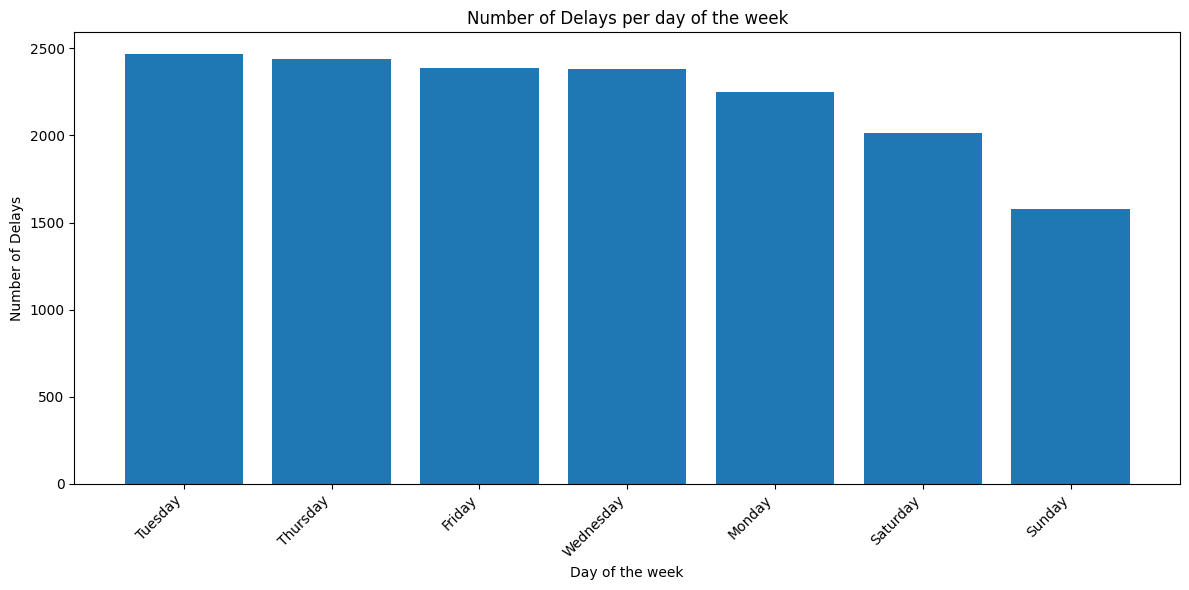

In [ ]:
# Top 10 stations with most delays 
not_null_df = df.dropna(inplace=False)
station_counts = not_null_df['Station'].value_counts().sort_values(ascending=False)
station_counts.head(10)
# Top 10 lines with most delays
line_counts = not_null_df['Line'].value_counts().sort_values(ascending=False).sort_values(ascending=False)
line_counts
# Days with the most delays
day_counts = not_null_df['Day'].value_counts()
day_counts
# Create a bar graph of the day_counts
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(day_counts.index, day_counts.values)
plt.xlabel('Day of the week')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per day of the week')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

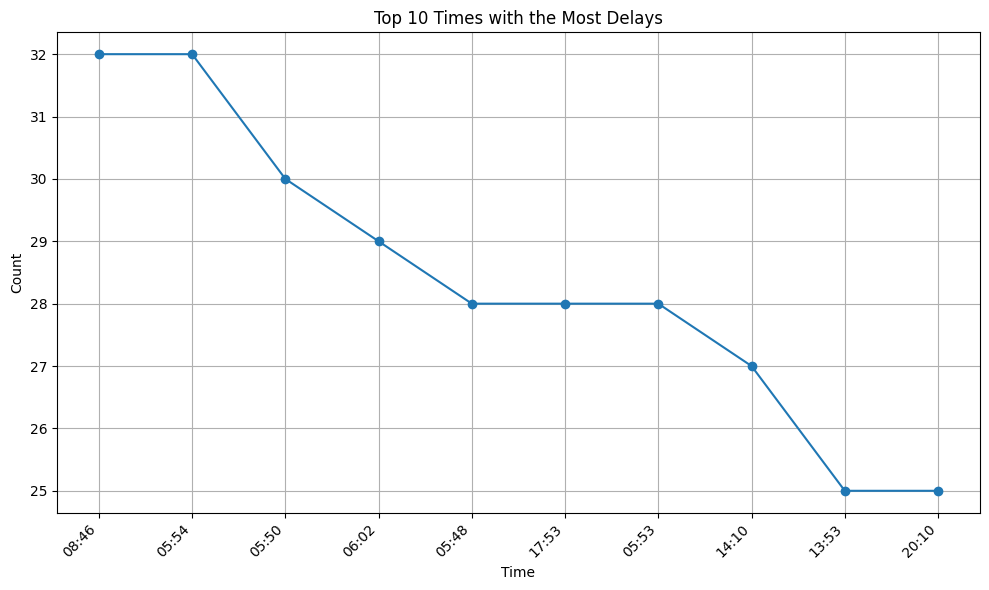

In [ ]:
# Time of the day with most delays
time_counts = not_null_df['Time'].value_counts()
time_counts.head(10)
# line graph using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(time_counts.head(10).index, time_counts.head(10).values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Top 10 Times with the Most Delays')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
# 2. Define label encoders for categorical variables
label_encoders = {} # A Mapping between categorical variables and their encoded values
for column in ['Station', 'Bound', 'Line']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = dict(zip(le.classes_, le.transform(le.classes_)))

print(label_encoders)
print(df.head())

{'Station': {'(APPROACHING) KENNEDY': 0, '111 SPADINA ROAD': 1, '1900 YONGE MCBRIEN BLD': 2, '1900 YONGE ST- MCBRIEN': 3, '2233 SHEPPARD WEST': 4, 'ALL STATIONS': 5, 'APPROACHING DUNDAS WES': 6, 'ASQUITH SUBSTATION': 7, 'BATHURST STATION': 8, 'BATHUST TO PAPE STATIO': 9, 'BAY LOWER': 10, 'BAY STATION': 11, 'BAY STATION TO PAPE ST': 12, 'BAYVIEW STATION': 13, 'BESSARION STATION': 14, 'BETWEEN WARDEN STATION': 15, 'BLOOR / DANFORTH LINE': 16, 'BLOOR DANFORTH LINE': 17, 'BLOOR DANFORTH LINE 2': 18, 'BLOOR DANFORTH SUBWAY': 19, 'BLOOR SATION': 20, 'BLOOR STATION': 21, 'BLOOR STATION - YONGE': 22, 'BROADVIEW AND ST GEORG': 23, 'BROADVIEW CENTRE TRACK': 24, 'BROADVIEW STATION': 25, 'BROADVIEW TO SCARBOROU': 26, 'BUCHAN ESB': 27, 'CASTLE FRANK STATION': 28, 'CHANGE OVERS': 29, 'CHANGE OVERS LINE TWO': 30, 'CHESTER STATION': 31, 'CHRISTIE CENTRE TRACK': 32, 'CHRISTIE STATION': 33, 'CHRISTIE STATION (LEAV': 34, 'CHRISTIE STATION TO CH': 35, 'CHRISTIE STATION TO PA': 36, 'CHRISTIE TO PAPE STATI'

In [4]:
numeric_cols = ["Hour", "DayOfWeek", "Month", "Minute"]
categorical_cols = ["Station", "Line", "Bound"]
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [5]:
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

In [6]:
# 4. Full pipeline: preprocessing + model
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor())
])

In [8]:
# 5. Time-based cross-validation + grid search
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    "model__n_estimators": [300],
    "model__learning_rate": [0.01]
}

In [9]:
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [ ]:
# 6. Fit and evaluate
grid.fit(X, y)
print("Best score:", -grid.best_score_)
print("Best params:", grid.best_params_)
grid_predictions = grid.predict(X)
print("Sample predictions:", grid_predictions[:5])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 0.39560331106185914
Best params: {'model__learning_rate': 0.01, 'model__n_estimators': 300}
Sample predictions: [0.3675128  0.3168893  0.47960114 0.45730382 0.49865547]
Accuracy: 0.7547052483210347


In [12]:
# Best pipeline found by GridSearchCV
best_pipeline = grid.best_estimator_

# Split into preprocessing and model
preprocessor = best_pipeline.named_steps["prep"]
model        = best_pipeline.named_steps["model"]
print("Preprocessor:", preprocessor)
print("Model:", model)

Preprocessor: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Hour', 'DayOfWeek', 'Month', 'Minute']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Station', 'Line', 'Bound'])])
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_b

Feature names: ['num__Hour' 'num__DayOfWeek' 'num__Month' 'num__Minute'
 'cat__Station_(APPROACHING) KENNEDY' 'cat__Station_111 SPADINA ROAD'
 'cat__Station_1900 YONGE MCBRIEN BLD'
 'cat__Station_1900 YONGE ST- MCBRIEN' 'cat__Station_2233 SHEPPARD WEST'
 'cat__Station_ALL STATIONS' 'cat__Station_APPROACHING DUNDAS WES'
 'cat__Station_ASQUITH SUBSTATION' 'cat__Station_BATHURST STATION'
 'cat__Station_BATHUST TO PAPE STATIO' 'cat__Station_BAY LOWER'
 'cat__Station_BAY STATION' 'cat__Station_BAY STATION TO PAPE ST'
 'cat__Station_BAYVIEW STATION' 'cat__Station_BESSARION STATION'
 'cat__Station_BETWEEN WARDEN STATION'
 'cat__Station_BLOOR / DANFORTH LINE' 'cat__Station_BLOOR DANFORTH LINE'
 'cat__Station_BLOOR DANFORTH LINE 2' 'cat__Station_BLOOR DANFORTH SUBWAY'
 'cat__Station_BLOOR SATION' 'cat__Station_BLOOR STATION'
 'cat__Station_BLOOR STATION - YONGE'
 'cat__Station_BROADVIEW AND ST GEORG'
 'cat__Station_BROADVIEW CENTRE TRACK' 'cat__Station_BROADVIEW STATION'
 'cat__Station_BROADVIE

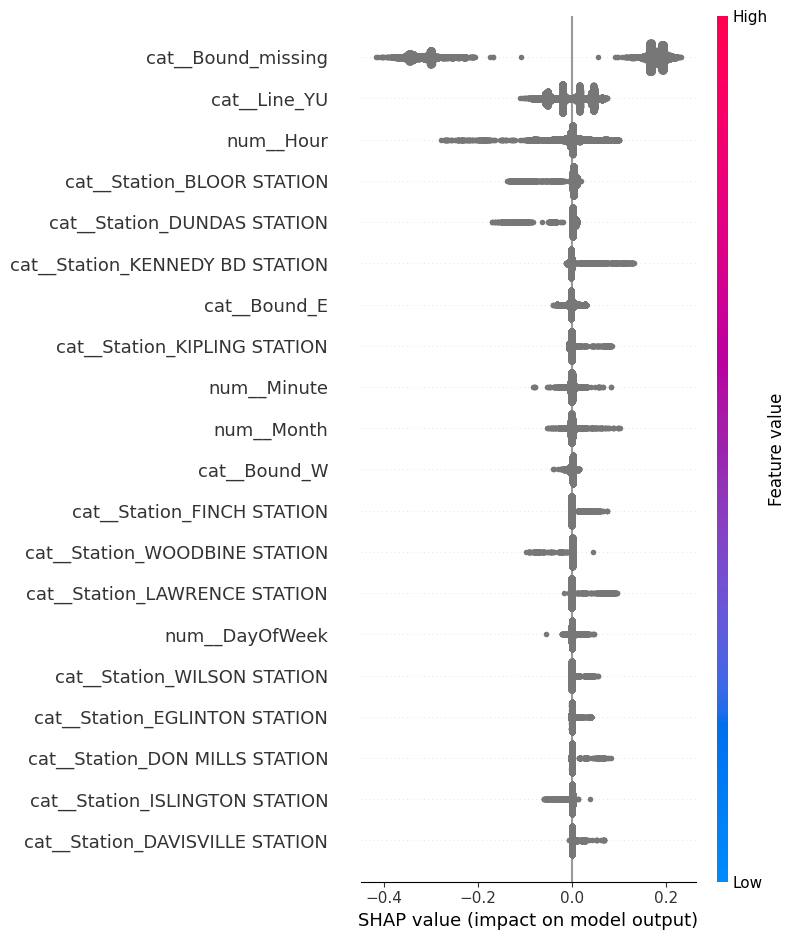

In [17]:
#get feature names
feature_names = preprocessor.get_feature_names_out()
print("Feature names:", feature_names)

# Compute SHAP values for the entire dataset
explainer = shap.Explainer(model)
shap_values = explainer(preprocessor.transform(X))
# Visualize SHAP values
shap.summary_plot(shap_values, feature_names=feature_names)



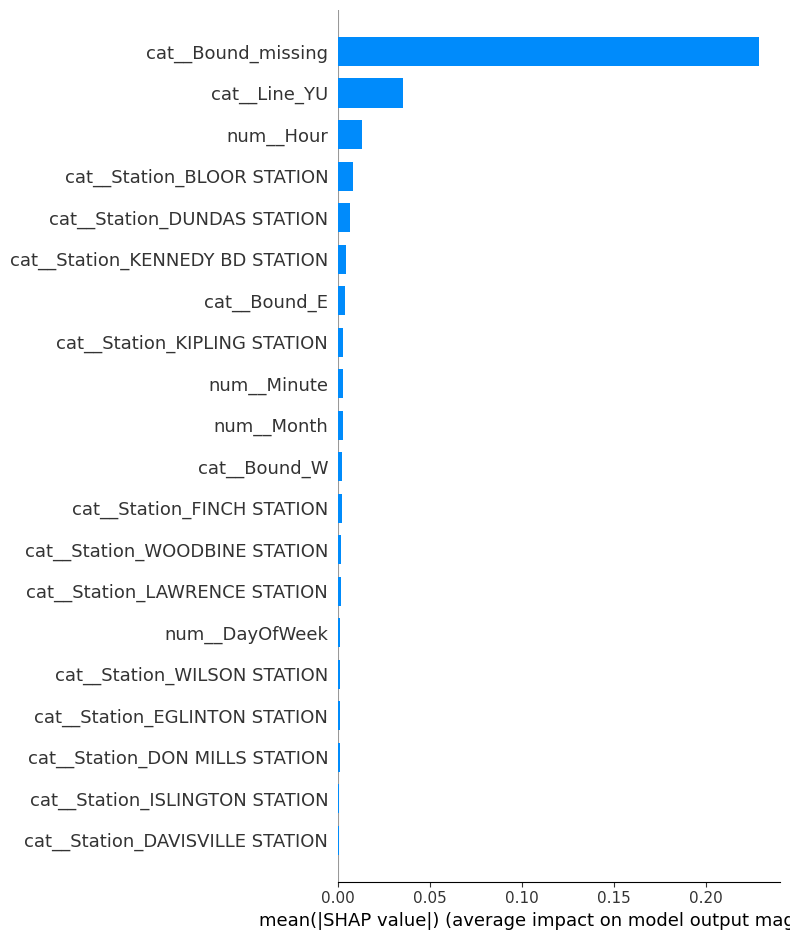

In [18]:
shap.summary_plot(
    shap_values, 
    preprocessor.transform(X), 
    feature_names=feature_names, 
    plot_type="bar"
)
